In [47]:
import pygplates
import sys
import numpy as np
sys.path.append('../../GPlatesClassStruggle')
sys.path.append('../../atom_utils')
from raster_reconstruction_classes import *
import matplotlib.pyplot as plt
from reconstruct_atom_rasters import *

%matplotlib inline
%load_ext autoreload
%autoreload 2


agegrid = GplatesRaster('../data/agegrid_6m.grd')

topography = GplatesRaster('../data/ETOPO1_0.1.grd')

rotation_filename = '/Users/Simon/GIT/agegrid-dev/input_files/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'
#static_polygon_filename = '/Users/Simon/GIT/agegrid-dev/input_files/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons_MOD.gpml'
static_polygon_filename = '/Users/Simon/GIT/passive_margins/input_data/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v1.shp'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
rotation_model = pygplates.RotationModel(rotation_filename)
features = pygplates.FeatureCollection(static_polygon_filename)


In [53]:
south_atlantic_polygons = []

for feature in features:

    plate_id = feature.get_reconstruction_plate_id()
    conj_plate_id = feature.get_conjugate_plate_id()
    
    if plate_id in [201,701] and conj_plate_id in [201,701]:
        south_atlantic_polygons.append(feature)

    

[-70, 30, -60, 15]

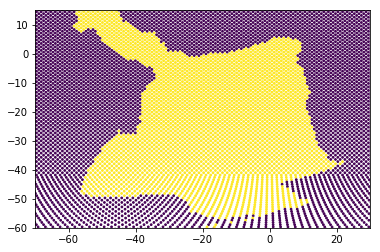

In [54]:
equal_area_points = PointDistributionOnSphere(distribution_type='healpix',N=64)

points = [point.to_lat_lon_point() for point in equal_area_points.multipoint.get_points()]

zval = run_grid_pip(0., points, south_atlantic_polygons, rotation_model)

plt.scatter(equal_area_points.longitude,equal_area_points.latitude,c=zval,s=3)
plt.axis([-70,30,-60,15])


In [55]:
import points_spatial_tree
import points_in_polygons

spatial_tree_of_uniform_recon_points = points_spatial_tree.PointsSpatialTree(points)

recon_static_polygons = []
recon_static_polygon_plate_ids = []
for static_polygon_feature in south_atlantic_polygons:
    recon_plate_id = static_polygon_feature.get_reconstruction_plate_id()
    recon_polygon = static_polygon_feature.get_geometry()

    recon_static_polygon_plate_ids.append(recon_plate_id)
    recon_static_polygons.append(recon_polygon)
        
point_plate_ids = points_in_polygons.find_polygons_using_points_spatial_tree(
    points, spatial_tree_of_uniform_recon_points, recon_static_polygons, recon_static_polygon_plate_ids)

point_ages = point_age = agegrid.sample_using_gmt(equal_area_points.longitude,equal_area_points.latitude)




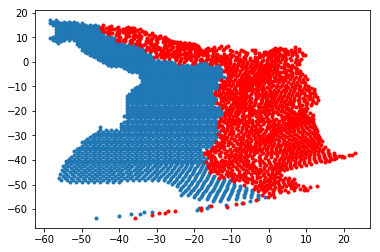

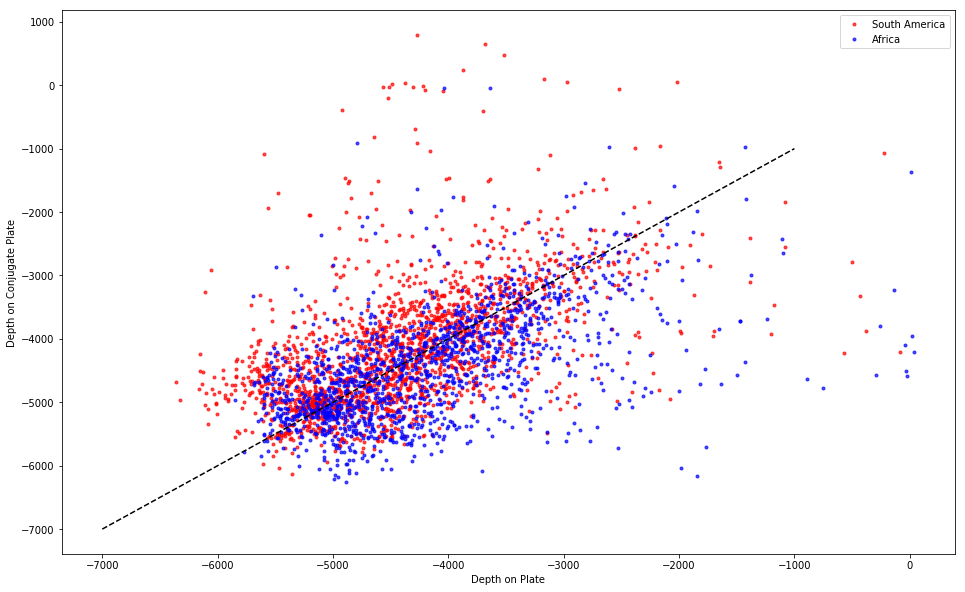

In [61]:
def return_conjugate_points(target_plate_id):

    points_and_conjugate_points = []
    for point, point_age, plate_id in zip(points, point_ages, point_plate_ids):

        if plate_id != target_plate_id:
            continue
        else:
            if plate_id==201:
                conj_plate_id = 701
            else:
                conj_plate_id = 201

            #print plate_id, conj_plate_id, point_age
            
            if not np.isnan(point_age):

                finite_rotation = rotation_model.get_rotation(float(point_age), int(plate_id), 0, int(conj_plate_id))

                reconstructed_point = finite_rotation * pygplates.PointOnSphere(point)

                points_and_conjugate_points.append([point.to_lat_lon()[1],
                                                    point.to_lat_lon()[0],
                                                    reconstructed_point.to_lat_lon()[1],
                                                    reconstructed_point.to_lat_lon()[0]])
            
    return points_and_conjugate_points

points_and_conjugate_points_201 = return_conjugate_points(201)
points_and_conjugate_points_701 = return_conjugate_points(701)

#print points_and_conjugate_points_701

plt.plot(zip(*points_and_conjugate_points_201)[0],zip(*points_and_conjugate_points_201)[1],'.')
plt.plot(zip(*points_and_conjugate_points_201)[2],zip(*points_and_conjugate_points_201)[3],'r.')
plt.show()

point_depth_201 = topography.sample_using_gmt(zip(*points_and_conjugate_points_201)[0],zip(*points_and_conjugate_points_201)[1])    
conj_point_depth_201 = topography.sample_using_gmt(zip(*points_and_conjugate_points_201)[2],zip(*points_and_conjugate_points_201)[3])

point_depth_701 = topography.sample_using_gmt(zip(*points_and_conjugate_points_701)[0],zip(*points_and_conjugate_points_701)[1])    
conj_point_depth_701 = topography.sample_using_gmt(zip(*points_and_conjugate_points_701)[2],zip(*points_and_conjugate_points_701)[3])

plt.figure(figsize=(16,10))
plt.plot(point_depth_201,conj_point_depth_201,'r.',alpha=0.7)
plt.plot(point_depth_701,conj_point_depth_701,'b.',alpha=0.7)
plt.plot([-7000,-1000],[-7000,-1000],'k--')
plt.xlabel('Depth on Plate')
plt.ylabel('Depth on Conjugate Plate')
plt.legend(['South America','Africa'])


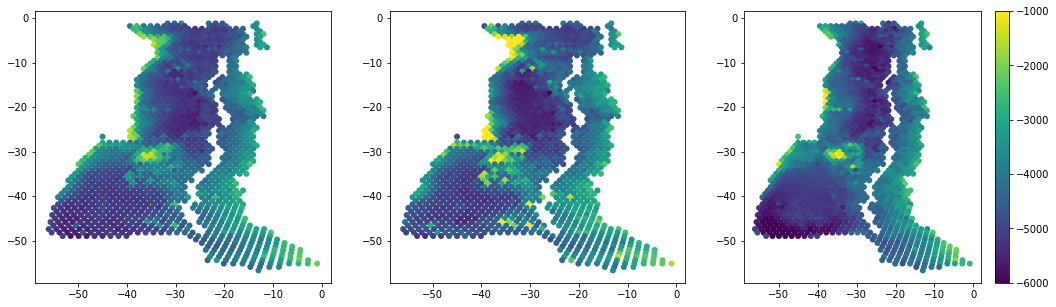

In [46]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.scatter(zip(*points_and_conjugate_points_201)[0],
            zip(*points_and_conjugate_points_201)[1],
            c=np.mean(np.vstack((point_depth_201,conj_point_depth_201)),axis=0),
            edgecolors='',vmin=-6000,vmax=-1000)
#plt.colorbar()
 
plt.subplot(132)
plt.scatter(zip(*points_and_conjugate_points_201)[0],
            zip(*points_and_conjugate_points_201)[1],
            c=conj_point_depth_201,
            edgecolors='',vmin=-6000,vmax=-1000)
#plt.colorbar()

plt.subplot(133)
plt.scatter(zip(*points_and_conjugate_points_201)[0],
            zip(*points_and_conjugate_points_201)[1],
            c=point_depth_201,
            edgecolors='',vmin=-6000,vmax=-1000)
plt.colorbar()